# Registration Evaluation

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import t
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from utils import convert_image_to_tensor
from plotting import plot_image_pair
from masking import fetch_image_mask_pair
from DatasetTools.LeafImageSeries import LeafDataset

In [3]:
df_full = pd.read_csv("registration_eval2.csv")
df_full.head()

leaf_uid registration_method  fixed_image  moving_image       MSE  \
0  ESWW0070020_1     Pairwise Affine            0             1  0.006813   
1  ESWW0070020_1     Pairwise Affine            0             2  0.024689   
2  ESWW0070020_1     Pairwise Affine            0             3  0.010441   
3  ESWW0070020_1     Pairwise Affine            0             4  0.033797   
4  ESWW0070020_1     Pairwise Affine            0             5  0.035394   

        NCC        MI      SSIM       IoU  Hausdorff  
0  0.015722  1.009170  0.313402  0.948756  56.320511  
1  0.010441  1.005553  0.238523  0.948640  56.320511  
2  0.018857  1.005519  0.256883  0.948681  56.320511  
3  0.022684  1.006689  0.213784  0.948755  56.320511  
4 -0.009654  1.004894  0.209419  0.948741  56.320511

In [4]:
n_uids = df_full['leaf_uid'].nunique()
print(f"Number of leafs evaluated: {n_uids}")

Number of leafs evaluated: 32


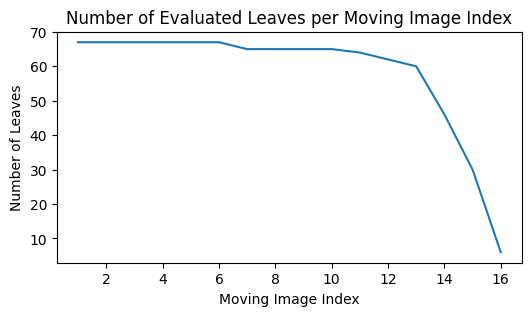

In [7]:
moving_img_ind_count = df_full['moving_image'].value_counts()
plt.figure(figsize=(6, 3))
plt.plot(moving_img_ind_count.index, moving_img_ind_count.values)
plt.title("Number of Evaluated Leaves per Moving Image Index")
plt.xlabel("Moving Image Index")
plt.ylabel("Number of Leaves")
plt.show()

In [5]:
metrics = ["MSE", "NCC", "MI", "SSIM", "IoU", "Hausdorff"]
group_cols = ['registration_method', 'fixed_image', 'moving_image']
methods = df_full["registration_method"].unique()


## Averages per time step

In [6]:
# average over leaf series for each index pair
df_agg = df_full.groupby(group_cols)[metrics].agg(["mean", "std"]).reset_index()
df_agg.columns = [ "_".join(col).rstrip("_") for col in df_agg.columns ]
df_agg.sample(5).sort_values(by=(['registration_method', 'fixed_image', 'moving_image']))

registration_method  fixed_image  moving_image  MSE_mean  \
1                LoFTR + TPS ROI            0             2  0.011360   
7                LoFTR + TPS ROI            0             8  0.019725   
18  LoFTR + TPS ROI with Markers            0             3  0.012738   
21  LoFTR + TPS ROI with Markers            0             6  0.025847   
37               Pairwise Affine            0             8  0.024062   

     MSE_std  NCC_mean   NCC_std   MI_mean    MI_std  SSIM_mean  SSIM_std  \
1   0.005896  0.109878  0.182501  1.013091  0.010533   0.435264  0.142811   
7   0.008459  0.154917  0.181765  1.005100  0.004470   0.451321  0.128332   
18  0.009677  0.068691  0.022329  1.011489  0.009558   0.238593  0.019113   
21  0.008768  0.032761  0.031543  1.004313  0.002297   0.250428  0.082731   
37  0.010162  0.076279  0.072303  1.009199  0.005005   0.307868  0.063126   

    IoU_mean   IoU_std  Hausdorff_mean  Hausdorff_std  
1   0.907206  0.087153       59.714812      88.487980  
7   0.928035  0.047592       38.132858      25.830876  
18  0.684117  0.037630      211.360447       3.810047  
21  0.749300  0.055474      205.813972      71.360658  
37  0.923985  0.021890       79.145486      48.193155

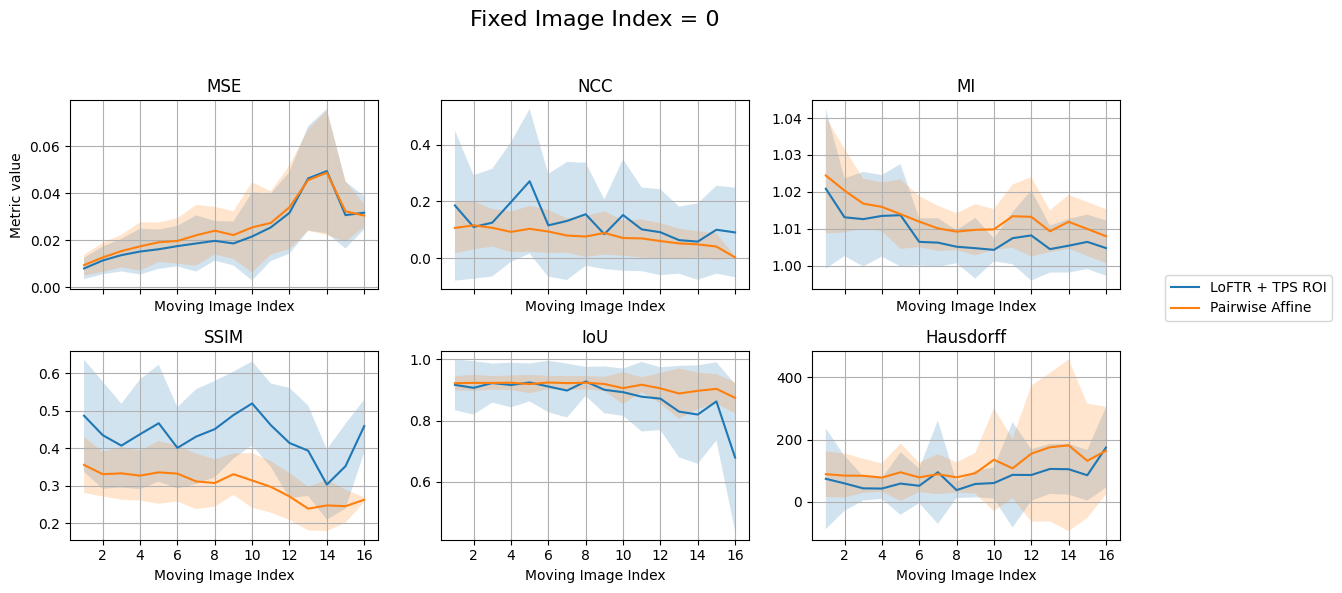

In [22]:
methods = ["LoFTR + TPS ROI", "Pairwise Affine"]
n_metrics = len(metrics)

n_rows = 2
n_cols = math.ceil(n_metrics / n_rows)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex=True,
    sharey=False
)

axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    for method in methods:
        df_plot = df_agg[
            (df_agg["fixed_image"] == 0) &
            (df_agg["registration_method"] == method) &
            (df_agg["moving_image"] != 0)
        ].sort_values("moving_image")

        if df_plot.empty:
            continue

        x = df_plot["moving_image"]
        mean = df_plot[f"{metric}_mean"]
        std = df_plot[f"{metric}_std"]

        ax.plot(x, mean, label=method)
        ax.fill_between(x, mean - std, mean + std, alpha=0.2, label="_nolegend_")

    ax.set_title(metric)
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Moving Image Index")

# hide unused subplots
for ax in axes[len(metrics):]:
    ax.set_visible(False)

# shared y-label
axes[0].set_ylabel("Metric value")

# put legend far right outside
fig.legend(
    methods,
    loc="center right",
    bbox_to_anchor=(1.12, 0.5)
)

fig.suptitle("Fixed Image Index = 0", fontsize=16)

# tighten layout to remove empty space
fig.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


## Distribution over leaves (averages over moving image index)

In [7]:
# average over leaf series over each index pair
df_agg_leaf = df_full.groupby(['leaf_uid', 'registration_method'])[metrics].agg(["mean", "std"]).reset_index()
df_agg_leaf.columns = [ "_".join(col).rstrip("_") for col in df_agg_leaf.columns ]
df_agg_leaf.sample(5).sort_values(by=(['registration_method']))

leaf_uid registration_method  MSE_mean   MSE_std  NCC_mean   NCC_std  \
14  ESWW0070020_5     LoFTR + TPS ROI  0.020545  0.011674  0.134279  0.140032   
43  ESWW0070025_1     LoFTR + TPS ROI  0.027605  0.026299  0.071025  0.042043   
24  ESWW0070023_1     LoFTR + TPS ROI  0.028421  0.022779  0.167656  0.237938   
2   ESWW0070020_1     Pairwise Affine  0.024148  0.012388  0.016002  0.013470   
62  ESWW0070040_1     Pairwise Affine  0.018844  0.007674  0.034649  0.038040   

     MI_mean    MI_std  SSIM_mean  SSIM_std  IoU_mean   IoU_std  \
14  1.006119  0.004497   0.403991  0.106901  0.951840  0.040101   
43  1.004741  0.003730   0.419990  0.106499  0.942925  0.047959   
24  1.010615  0.012966   0.425356  0.147333  0.946734  0.031979   
2   1.005444  0.001455   0.270363  0.036953  0.948071  0.001268   
62  1.022081  0.011259   0.314383  0.044151  0.907885  0.023042   

    Hausdorff_mean  Hausdorff_std  
14       34.387931      37.549401  
43       41.155744      40.572885  
24       50.151496      84.041887  
2        56.655817       1.022202  
62       91.284848      62.201661

In [25]:
df_agg_leaf_melt = df_agg_leaf.melt(id_vars=['leaf_uid','registration_method'], value_vars=['MSE_mean', 'NCC_mean', 'MI_mean', 'SSIM_mean', 'IoU_mean', 'Hausdorff_mean'],)
df_agg_leaf_melt.sample(5)

leaf_uid           registration_method        variable       value
399  ESWW0070040_10               Pairwise Affine  Hausdorff_mean  144.406867
394   ESWW0070025_9               LoFTR + TPS ROI  Hausdorff_mean  125.060638
275   ESWW0070020_2  LoFTR + TPS ROI with Markers        IoU_mean    0.702552
137  ESWW0070020_10               LoFTR + TPS ROI         MI_mean    1.010271
297   ESWW0070023_2               Pairwise Affine        IoU_mean    0.916552

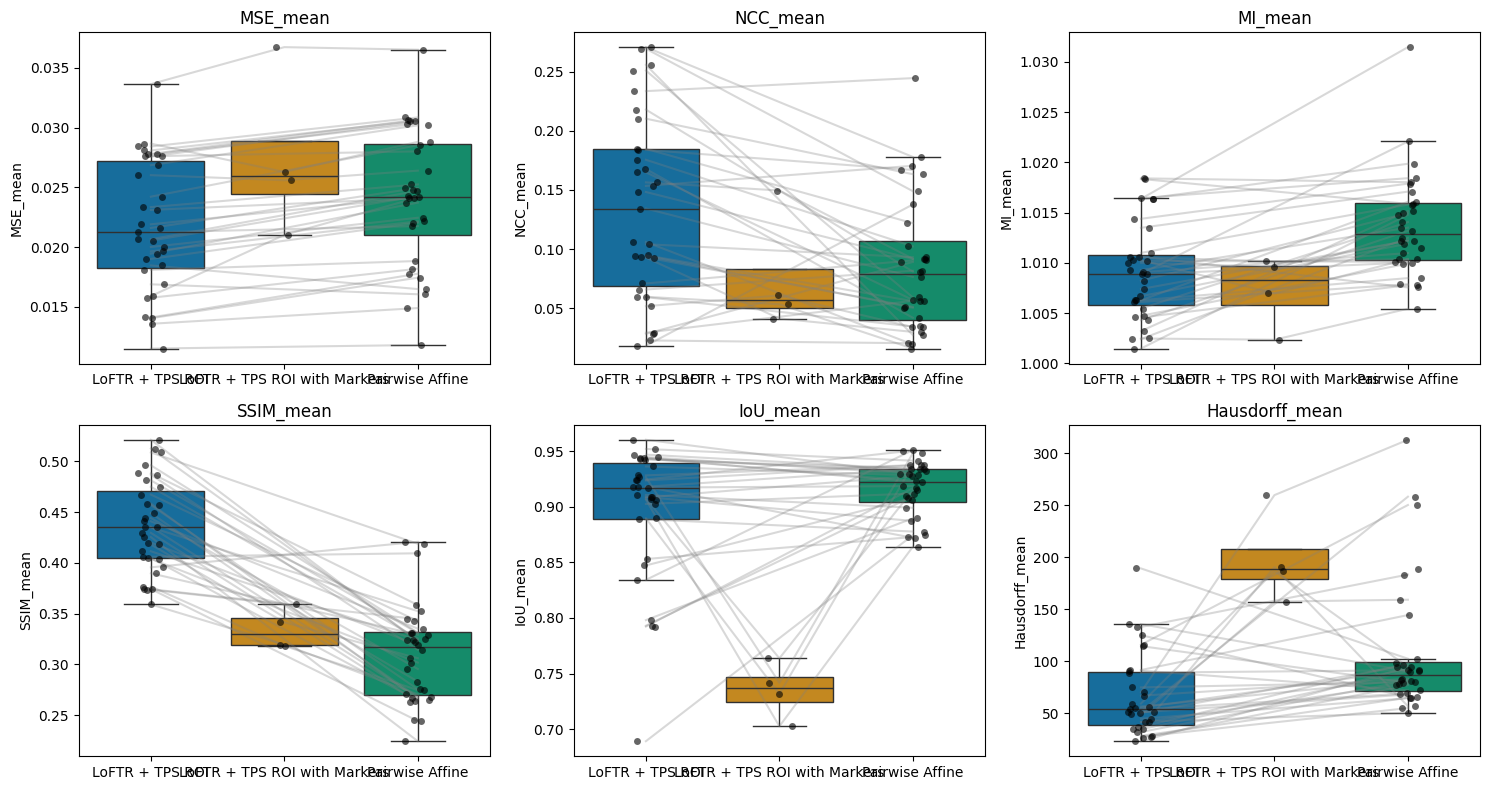

In [26]:
def plot_metrics_boxplots(df, metrics, method_col="registration_method", value_col="value", id_col="leaf_uid", plot_lines=False):
    n_metrics = len(metrics)

    fig, axes = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(15, 8),
        sharey=False
    )

    axes = axes.flatten()

    methods = df[method_col].unique()
    palette = dict(zip(methods, sns.color_palette("colorblind", len(methods))))

    for ax, metric in zip(axes, metrics):
        data_m = df[df["variable"] == metric]

        sns.boxplot(
            data=data_m,
            x=method_col,
            y=value_col,
            ax=ax,
            hue=method_col,
            palette=palette,
            showfliers=False
        )

        sns.stripplot(
            data=data_m,
            x=method_col,
            y=value_col,
            ax=ax,
            color="black",
            alpha=0.6,
            jitter=True
        )

        if plot_lines:
            sns.lineplot(
                data=data_m,
                x=method_col,
                y=value_col,
                units="leaf_uid",
                estimator=None,
                color="gray",
                alpha=0.3,
                ax=ax
            )


        ax.set_title(metric)
        ax.set_xlabel("")
        ax.set_ylabel(metric)

    # Remove unused axes if metrics < grid size
    for ax in axes[len(metrics):]:
        ax.remove()

    plt.tight_layout()
    plt.show()

plot_metrics_boxplots(df_agg_leaf_melt, [metric + "_mean" for metric in metrics], plot_lines=True)

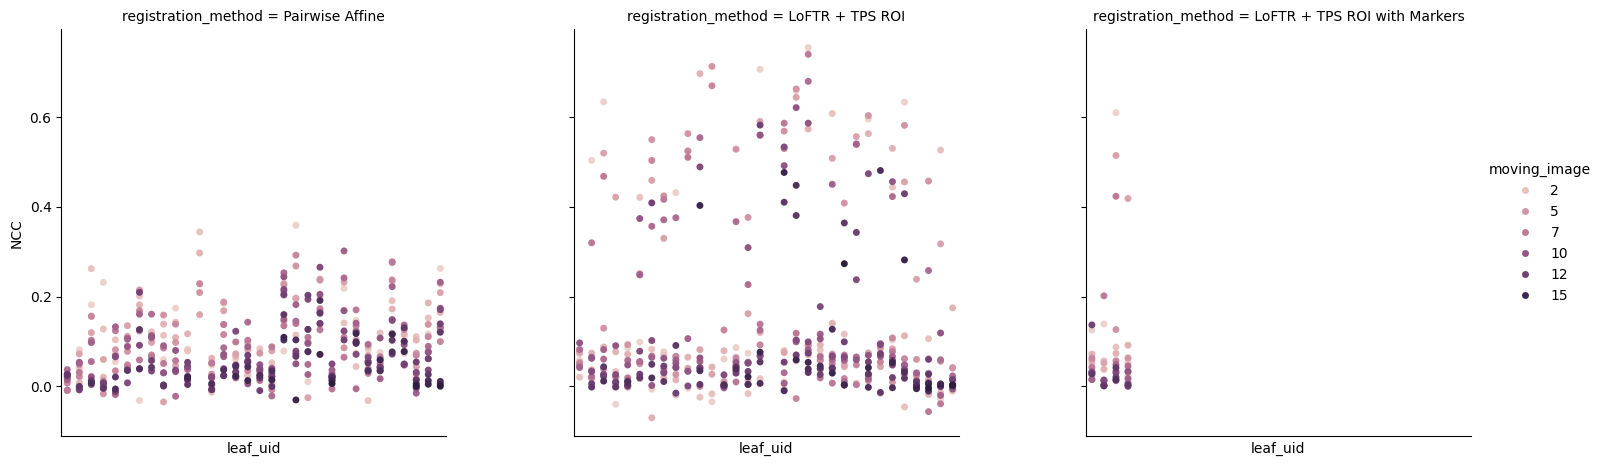

In [29]:
sns.catplot(data=df_full, x="leaf_uid", y="NCC", jitter=False, hue="moving_image", native_scale=True, col="registration_method")
plt.xticks([])
plt.show()

## Worst Performance

In [8]:
df_flagged = df_agg_leaf.copy()
df_flagged["bad"] = (
    df_flagged
    .groupby("registration_method")["Hausdorff_mean"]
    .rank(method="first", ascending=False)
    <= 10
)
df_flagged[df_flagged["bad"]][['leaf_uid', 'registration_method', 'Hausdorff_mean']].sort_values(by=["Hausdorff_mean"], ascending=[False]).head(7)

leaf_uid           registration_method  Hausdorff_mean
8   ESWW0070020_2               Pairwise Affine      313.099718
7   ESWW0070020_2  LoFTR + TPS ROI with Markers      259.836291
56  ESWW0070025_7               Pairwise Affine      258.327271
54  ESWW0070025_6               Pairwise Affine      250.314862
1   ESWW0070020_1  LoFTR + TPS ROI with Markers      190.493446
65  ESWW0070040_2               LoFTR + TPS ROI      189.291399
36  ESWW0070023_6               Pairwise Affine      188.984180

In [ ]:
bad_counts = (
    df_flagged[df_flagged["bad"]]
    .groupby("leaf_uid")["registration_method"]
    .nunique()
)

leaves_bad_in_one_method = bad_counts[bad_counts == 1].index#.tolist()

df_flagged[
    (df_flagged["bad"]) &
    (df_flagged["leaf_uid"].isin(leaves_bad_in_one_method))
][["leaf_uid", "registration_method", "Hausdorff_mean"]].sort_values(by=["Hausdorff_mean"], ascending=False)

leaf_uid           registration_method  Hausdorff_mean
56   ESWW0070025_7               Pairwise Affine      258.327271
1    ESWW0070020_1  LoFTR + TPS ROI with Markers      190.493446
36   ESWW0070023_6               Pairwise Affine      188.984180
4   ESWW0070020_10  LoFTR + TPS ROI with Markers      186.549997
28   ESWW0070023_2               LoFTR + TPS ROI      135.721642
59   ESWW0070025_9               LoFTR + TPS ROI      125.060638
12   ESWW0070020_4               LoFTR + TPS ROI      114.547656
27  ESWW0070023_10               Pairwise Affine       98.057760
25   ESWW0070023_1               Pairwise Affine       96.436785
34   ESWW0070023_5               LoFTR + TPS ROI       90.942395
61   ESWW0070040_1               LoFTR + TPS ROI       88.957162
32   ESWW0070023_4               LoFTR + TPS ROI       74.813625

#### Inspection

In [46]:
uid = "ESWW0070023_10" #"ESWW0070025_7" "ESWW0070020_2"
df_full[df_full['leaf_uid'] == uid].sort_values(by=['Hausdorff', 'IoU'], ascending=[False, True])

leaf_uid registration_method  fixed_image  moving_image       MSE  \
291  ESWW0070023_10     Pairwise Affine            0             3  0.026432   
297  ESWW0070023_10     LoFTR + TPS ROI            0             3  0.026121   
292  ESWW0070023_10     Pairwise Affine            0             4  0.012062   
290  ESWW0070023_10     Pairwise Affine            0             2  0.009582   
294  ESWW0070023_10     Pairwise Affine            0             6  0.012778   
293  ESWW0070023_10     Pairwise Affine            0             5  0.020330   
289  ESWW0070023_10     Pairwise Affine            0             1  0.008278   
296  ESWW0070023_10     LoFTR + TPS ROI            0             2  0.010657   
298  ESWW0070023_10     LoFTR + TPS ROI            0             4  0.010853   
299  ESWW0070023_10     LoFTR + TPS ROI            0             5  0.017420   
295  ESWW0070023_10     LoFTR + TPS ROI            0             1  0.008031   
300  ESWW0070023_10     LoFTR + TPS ROI            0             6  0.008476   

          NCC        MI      SSIM       IoU   Hausdorff  
291  0.297080  1.019279  0.385791  0.894820  238.346558  
297  0.042932  1.008817  0.514820  0.877566   70.710678  
292  0.159502  1.013638  0.377413  0.941761   70.000000  
290  0.343835  1.058519  0.481673  0.942035   70.000000  
294  0.228376  1.013735  0.429413  0.942045   70.000000  
293  0.208974  1.019164  0.379952  0.942073   70.000000  
289  0.228845  1.064466  0.458446  0.942078   70.000000  
296 -0.016736  1.020936  0.460128  0.947161   37.000000  
298  0.027050  1.002217  0.299147  0.953580   30.649902  
299  0.712469  1.025844  0.662793  0.955628   30.000000  
295 -0.034276  1.025601  0.437756  0.963503   26.000000  
300  0.669310  1.014819  0.678136  0.956697   25.179358

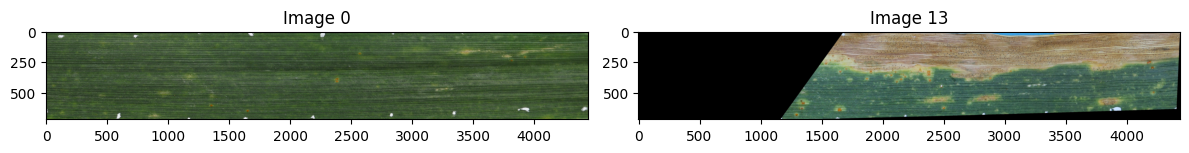

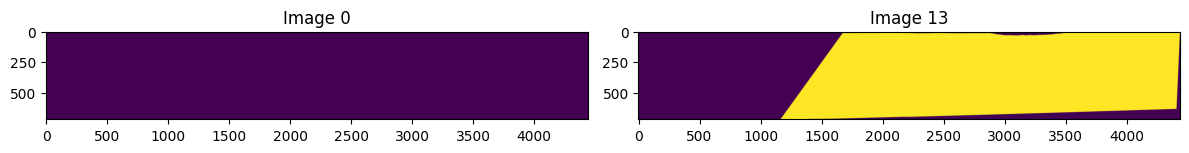

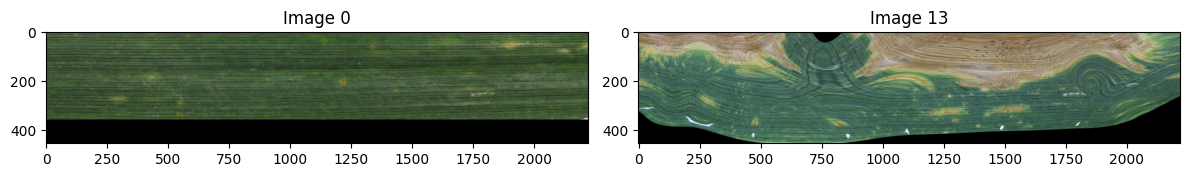

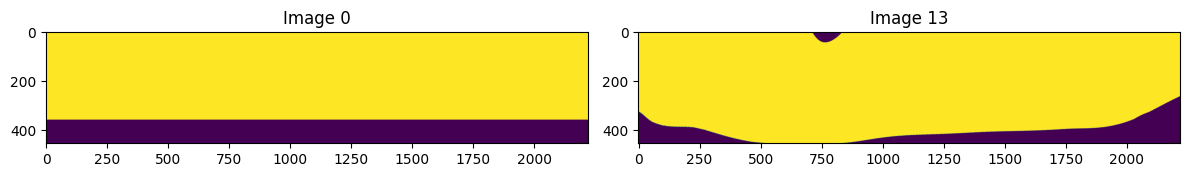

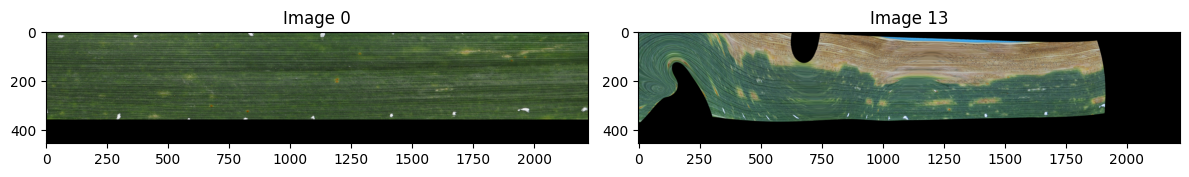

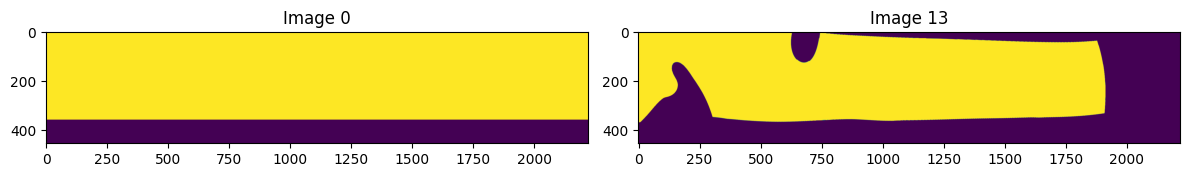

In [11]:
# all are bad
moving_ind = 13

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070020_2", 
    load=('target_images', 'target_masks', 'leaf_masks', 'rois', 'images', 'keypoints'),
    verbose=False
)

fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI with Markers")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()

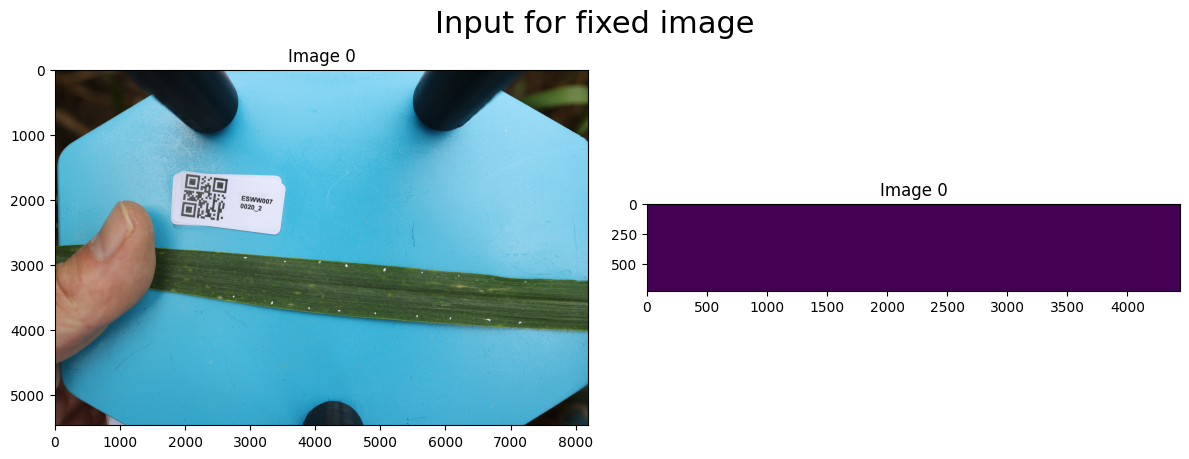

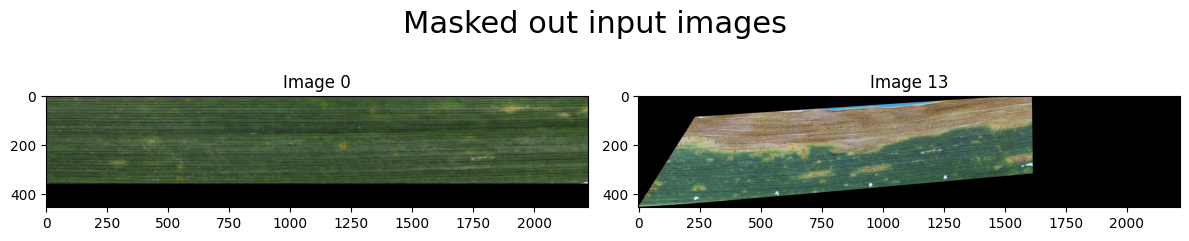

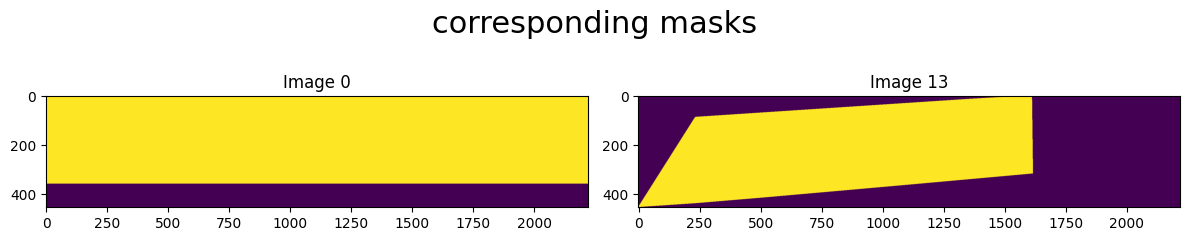

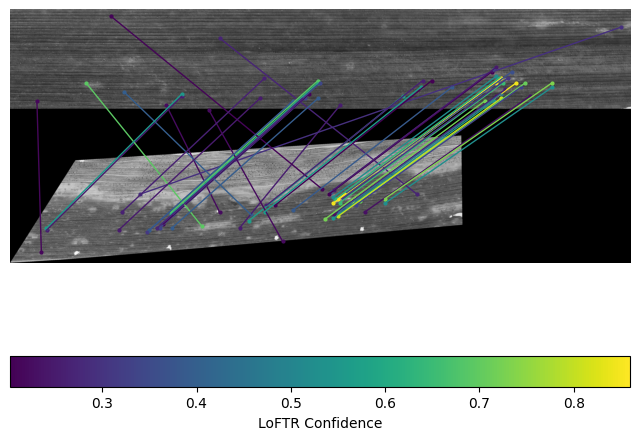

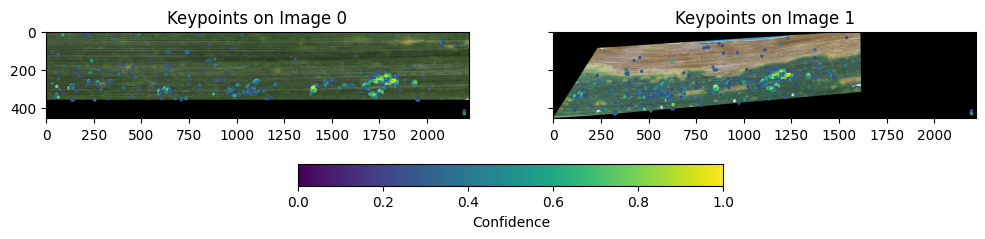

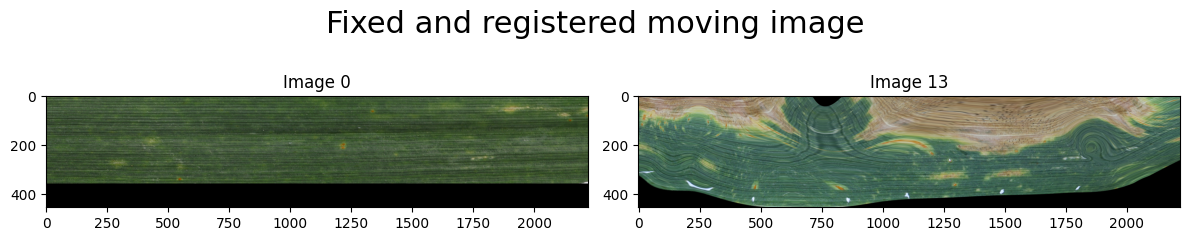

In [12]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI", plot_masked_images=True, plot_loftr_matches=True)
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind, title="Fixed and registered moving image", title_offset=0.7)
fig.show()

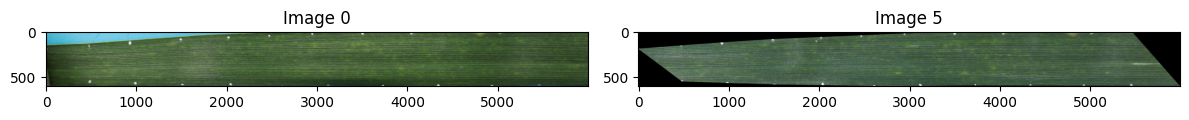

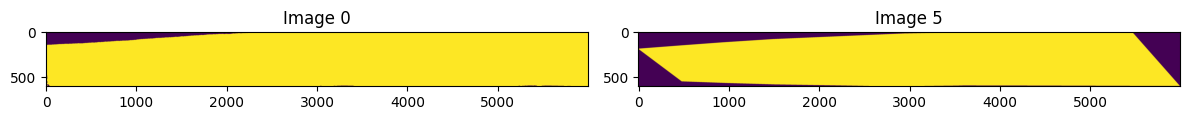

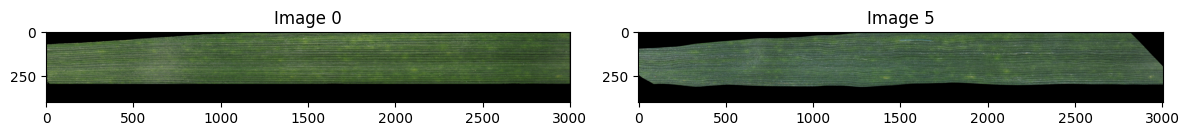

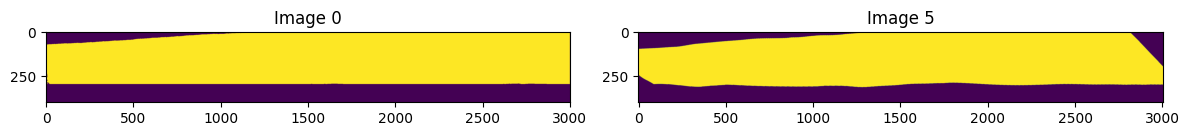

In [44]:
# piecewise bad, loftr good
moving_ind = 5

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070025_7", 
    load=('target_images', 'target_masks', 'leaf_masks', 'rois', 'images', 'keypoints'),
    verbose=False
)

fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
# fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI with Markers")
# fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
# fig.show()
# fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
# fig.show()

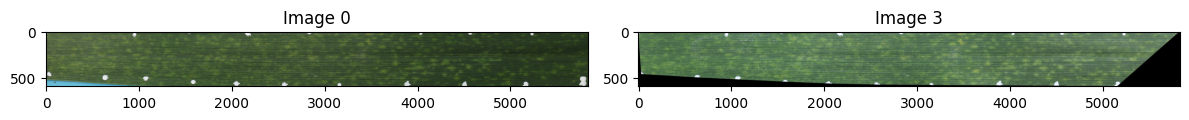

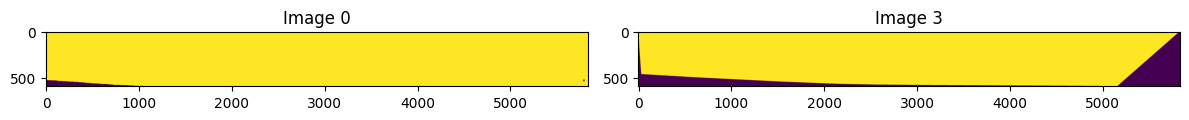

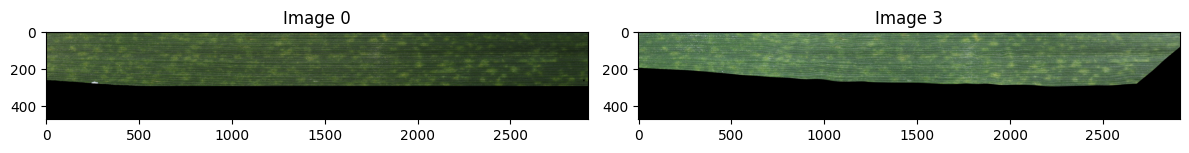

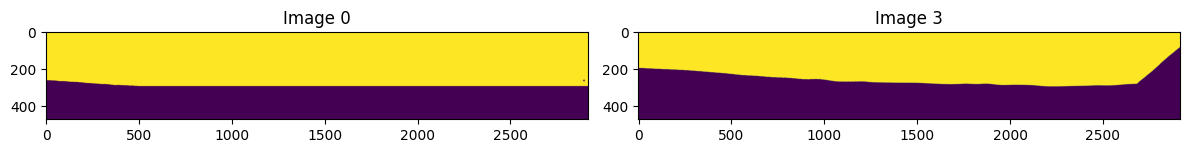

In [13]:
# piecewise bad, loftr not as bad?
moving_ind = 3

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070023_10", 
    load=('target_images', 'target_masks', 'leaf_masks', 'rois', 'images', 'keypoints'),
    verbose=False
)

fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
# fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI with Markers")
# fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
# fig.show()
# fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
# fig.show()

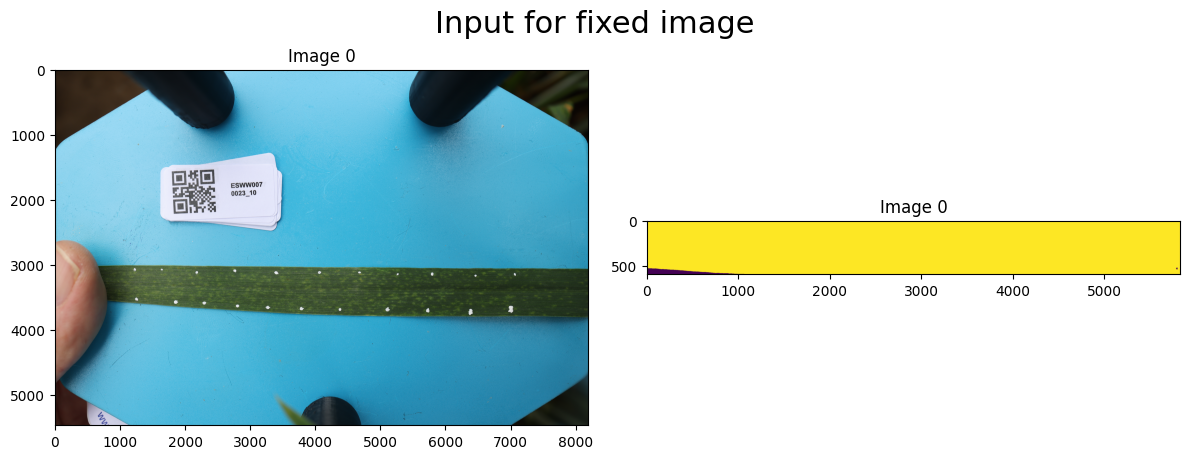

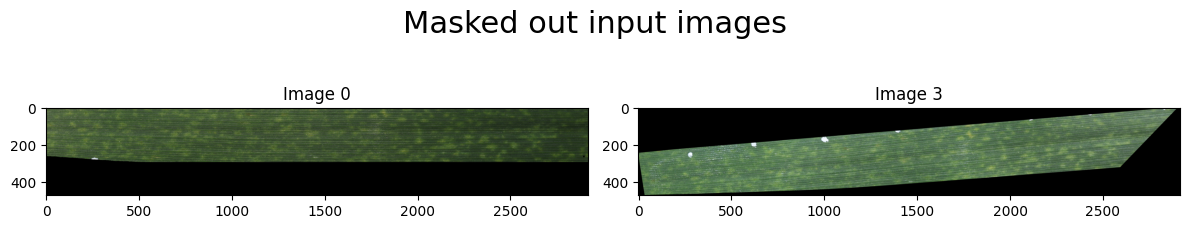

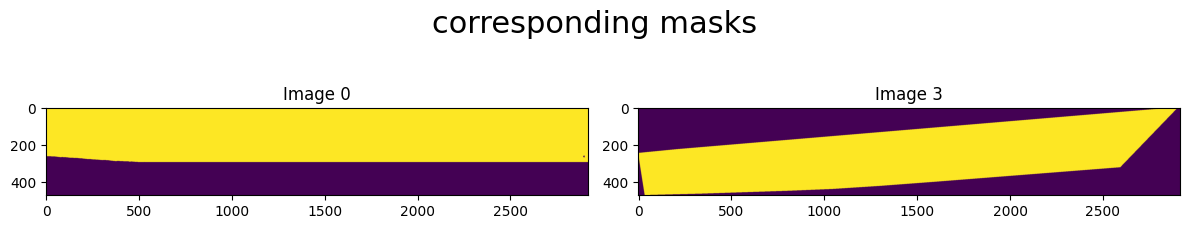

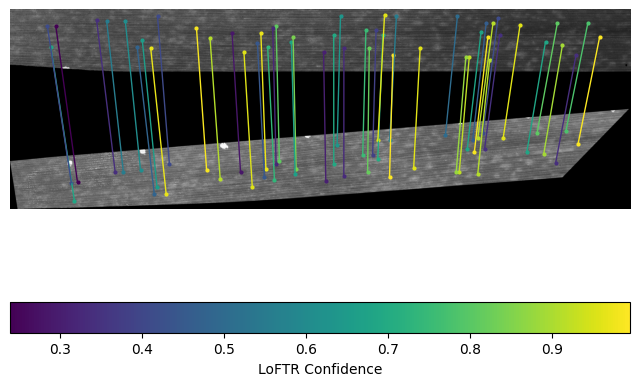

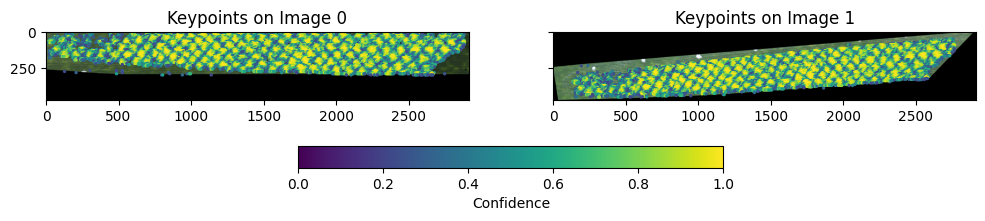

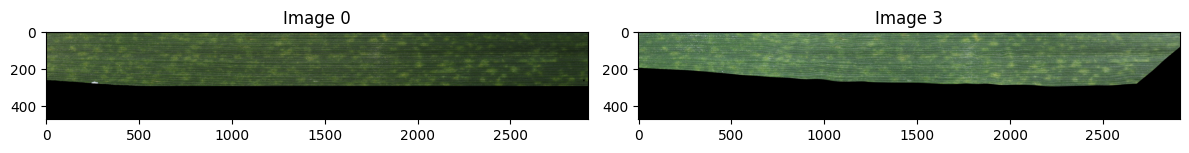

In [14]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI", plot_masked_images=True, plot_loftr_matches=True)
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_outdoor.ckpt" to /home/renku/.cache/torch/hub/checkpoints/loftr_outdoor.ckpt


100%|██████████| 44.2M/44.2M [00:00<00:00, 150MB/s] 


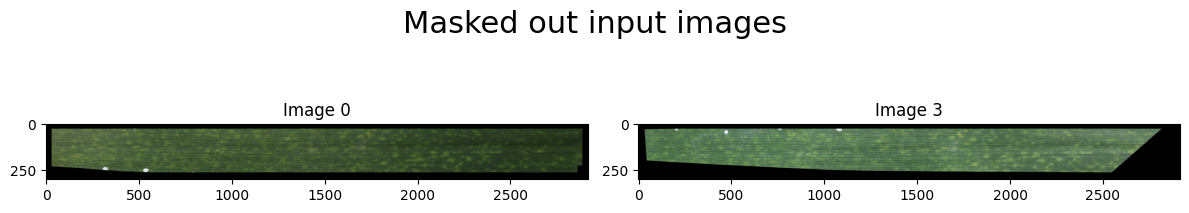

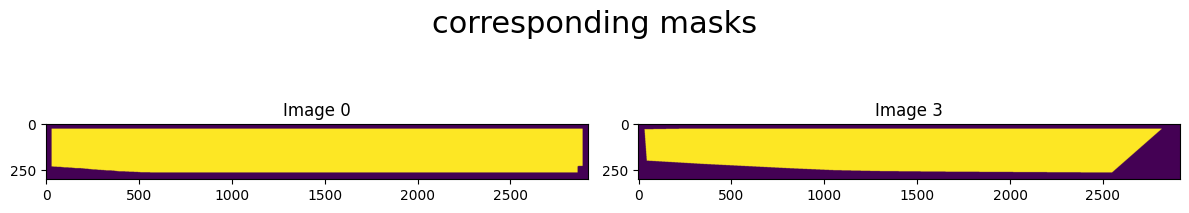

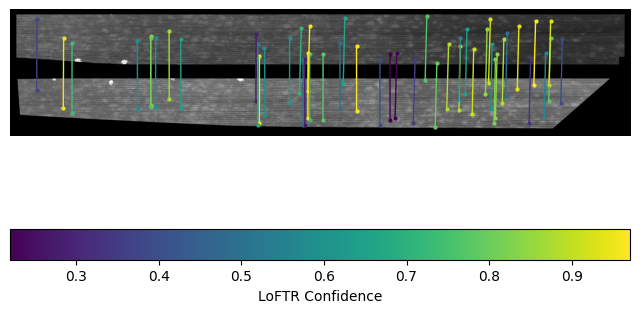

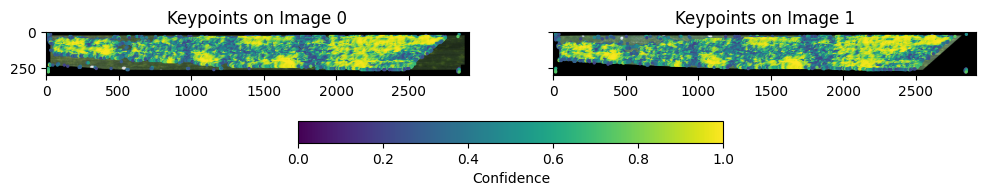

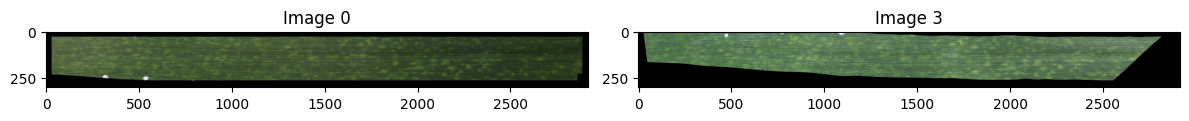

In [9]:
# new masking strategy

moving_ind = 3

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070023_10", 
    load=('target_images', 'target_masks', 'leaf_masks', 'rois', 'images', 'keypoints'),
    verbose=False
)

fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI", plot_masked_images=True, plot_loftr_matches=True)
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()

## Best Performance

In [10]:
# df_flagged = df_agg_leaf.copy()
df_flagged["good"] = (
    df_flagged
    .groupby("registration_method")["Hausdorff_mean"]
    .rank(method="first", ascending=True)
    <= 10
)
df_flagged[df_flagged["good"]][['leaf_uid', 'registration_method', 'Hausdorff_mean']].sort_values(by=["Hausdorff_mean"], ascending=[True]).head(7)

leaf_uid registration_method  Hausdorff_mean
57   ESWW0070025_8     LoFTR + TPS ROI       23.005236
39   ESWW0070023_8     LoFTR + TPS ROI       26.042439
45  ESWW0070025_10     LoFTR + TPS ROI       27.397930
22   ESWW0070020_9     LoFTR + TPS ROI       28.180877
41   ESWW0070023_9     LoFTR + TPS ROI       31.840501
14   ESWW0070020_5     LoFTR + TPS ROI       34.387931
0    ESWW0070020_1     LoFTR + TPS ROI       35.034655

In [11]:
good_counts = (
    df_flagged[df_flagged["good"]]
    .groupby("leaf_uid")["registration_method"]
    .nunique()
)

leaves_good_in_one_method = good_counts[good_counts == 1].index#.tolist()

df_flagged[
    (df_flagged["good"]) &
    (df_flagged["leaf_uid"].isin(leaves_good_in_one_method))
][["leaf_uid", "registration_method", "Hausdorff_mean"]].sort_values(by=["Hausdorff_mean"], ascending=True)


leaf_uid           registration_method  Hausdorff_mean
57   ESWW0070025_8               LoFTR + TPS ROI       23.005236
41   ESWW0070023_9               LoFTR + TPS ROI       31.840501
14   ESWW0070020_5               LoFTR + TPS ROI       34.387931
26  ESWW0070023_10               LoFTR + TPS ROI       36.589990
43   ESWW0070025_1               LoFTR + TPS ROI       41.155744
31   ESWW0070023_3               Pairwise Affine       64.418194
60   ESWW0070025_9               Pairwise Affine       65.633580
17   ESWW0070020_6               Pairwise Affine       68.007355
38   ESWW0070023_7               Pairwise Affine       69.000000
35   ESWW0070023_5               Pairwise Affine       72.000000
10   ESWW0070020_3  LoFTR + TPS ROI with Markers      157.336983
4   ESWW0070020_10  LoFTR + TPS ROI with Markers      186.549997
7    ESWW0070020_2  LoFTR + TPS ROI with Markers      259.836291

#### Inspection

In [17]:
uid = "ESWW0070023_8" #"ESWW0070025_8"
df_full[df_full['leaf_uid'] == uid].sort_values(by=['Hausdorff', 'IoU'], ascending=[True, False])

leaf_uid registration_method  fixed_image  moving_image       MSE  \
488  ESWW0070023_8     LoFTR + TPS ROI            0            13  0.075419   
487  ESWW0070023_8     LoFTR + TPS ROI            0            12  0.034542   
479  ESWW0070023_8     LoFTR + TPS ROI            0             4  0.011038   
485  ESWW0070023_8     LoFTR + TPS ROI            0            10  0.010221   
486  ESWW0070023_8     LoFTR + TPS ROI            0            11  0.025984   
490  ESWW0070023_8     LoFTR + TPS ROI            0            15  0.026758   
477  ESWW0070023_8     LoFTR + TPS ROI            0             2  0.010528   
483  ESWW0070023_8     LoFTR + TPS ROI            0             8  0.018280   
480  ESWW0070023_8     LoFTR + TPS ROI            0             5  0.009766   
478  ESWW0070023_8     LoFTR + TPS ROI            0             3  0.029228   
484  ESWW0070023_8     LoFTR + TPS ROI            0             9  0.018182   
476  ESWW0070023_8     LoFTR + TPS ROI            0             1  0.016635   
482  ESWW0070023_8     LoFTR + TPS ROI            0             7  0.025225   
489  ESWW0070023_8     LoFTR + TPS ROI            0            14  0.075346   
481  ESWW0070023_8     LoFTR + TPS ROI            0             6  0.034096   
473  ESWW0070023_8     Pairwise Affine            0            13  0.073732   
472  ESWW0070023_8     Pairwise Affine            0            12  0.035917   
471  ESWW0070023_8     Pairwise Affine            0            11  0.032459   
474  ESWW0070023_8     Pairwise Affine            0            14  0.075156   
461  ESWW0070023_8     Pairwise Affine            0             1  0.021338   
475  ESWW0070023_8     Pairwise Affine            0            15  0.027077   
470  ESWW0070023_8     Pairwise Affine            0            10  0.015971   
469  ESWW0070023_8     Pairwise Affine            0             9  0.023737   
467  ESWW0070023_8     Pairwise Affine            0             7  0.027541   
462  ESWW0070023_8     Pairwise Affine            0             2  0.011576   
463  ESWW0070023_8     Pairwise Affine            0             3  0.030719   
464  ESWW0070023_8     Pairwise Affine            0             4  0.017315   
465  ESWW0070023_8     Pairwise Affine            0             5  0.012306   
468  ESWW0070023_8     Pairwise Affine            0             8  0.019587   
466  ESWW0070023_8     Pairwise Affine            0             6  0.034232   

          NCC        MI      SSIM       IoU  Hausdorff  
488  0.380402  1.018056  0.587021  0.971133  18.000000  
487  0.070021  1.026559  0.453349  0.958641  19.104973  
479  0.643656  1.032815  0.633451  0.965117  21.000000  
485  0.620650  1.005362  0.685846  0.968775  23.000000  
486  0.103036  1.001332  0.527293  0.954247  24.000000  
490  0.058899  1.003813  0.292446  0.969076  24.020824  
477  0.056519  1.008628  0.480410  0.936982  24.738634  
483  0.102059  1.007732  0.316592  0.966300  25.109699  
480  0.662146  1.060622  0.659368  0.968399  26.000000  
478  0.065699  1.003992  0.235161  0.954457  27.000000  
484  0.099170  1.001525  0.465667  0.964305  28.500702  
476  0.658201  1.063523  0.657549  0.956137  31.000000  
482  0.118189  1.012715  0.496442  0.961158  32.029659  
489  0.447584  1.027433  0.398517  0.962807  33.000000  
481 -0.027232  1.002134  0.330216  0.944123  34.132095  
473  0.159835  1.017003  0.226429  0.929516  77.000000  
472  0.204253  1.047470  0.366998  0.929515  77.000000  
471  0.215791  1.004993  0.359239  0.929513  77.000000  
474  0.103165  1.024803  0.217679  0.929510  77.000000  
461  0.078873  1.044708  0.316297  0.929508  77.000000  
475  0.109204  1.009482  0.282924  0.929505  77.000000  
470  0.243805  1.005975  0.404204  0.929490  77.000000  
469  0.148791  1.006269  0.358897  0.929485  77.000000  
467  0.134933  1.011398  0.298555  0.929483  77.000000  
462  0.230021  1.021216  0.385742  0.929471  77.000000  
463  0.145300  1.008582  0.306620  0.929437  77.000000  
464  0.202763  1.0115

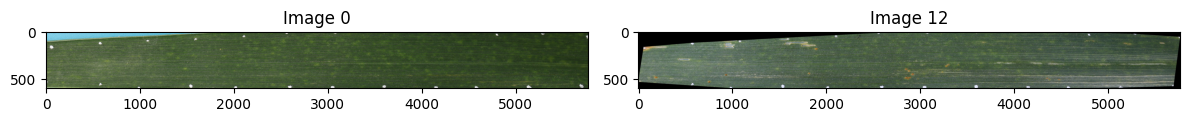

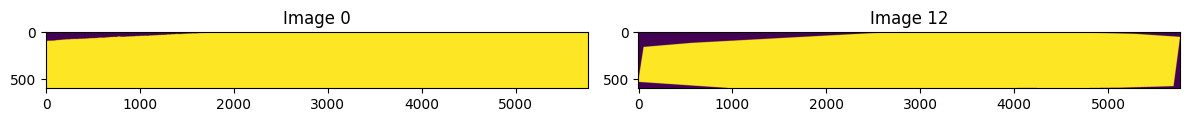

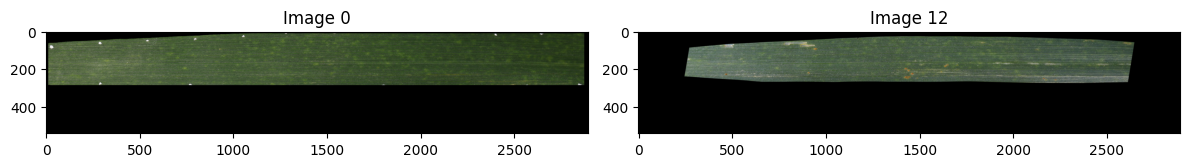

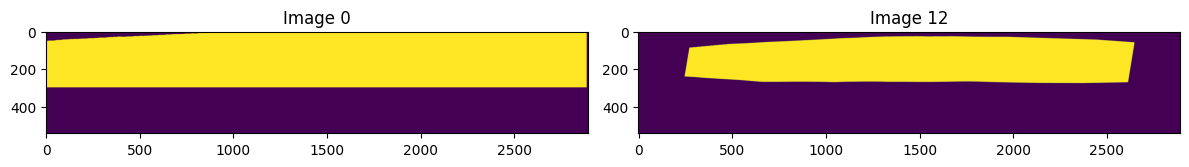

In [ ]:
# loftr good, piecewise less good
moving_ind = 12

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070025_8", 
    load=('target_images', 'target_masks', 'leaf_masks', 'rois', 'images', 'keypoints'),
    verbose=False
)

fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI", old=True)
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
# fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI with Markers")
# fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
# fig.show()
# fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
# fig.show()

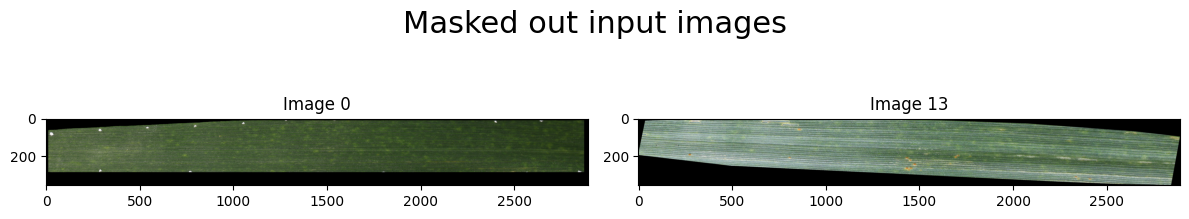

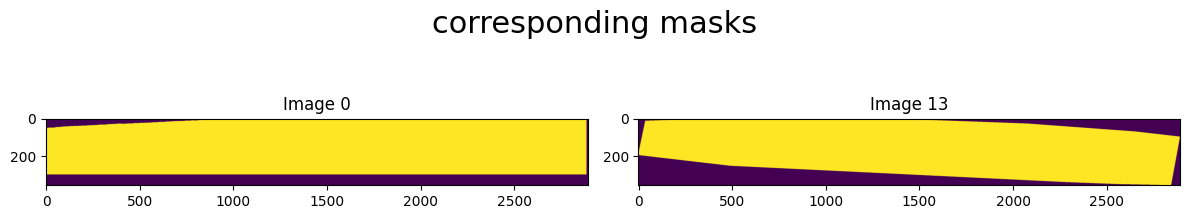

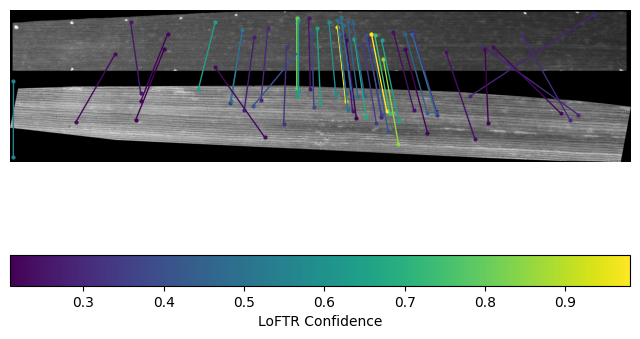

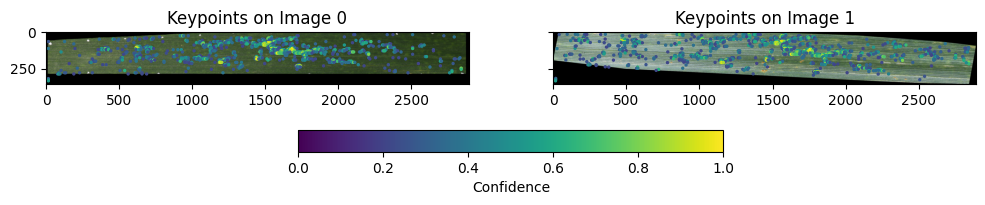

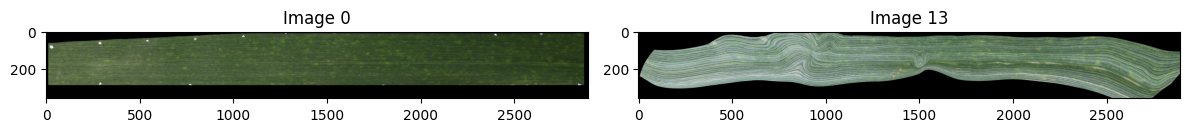

In [15]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI", old=True, plot_masked_images=True, plot_loftr_matches=True)
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()

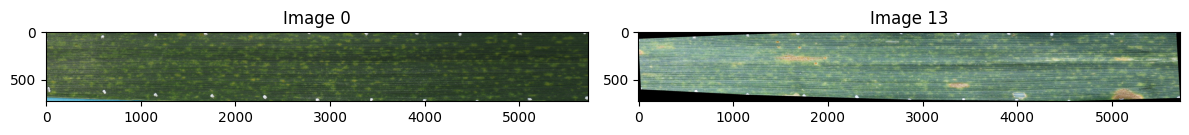

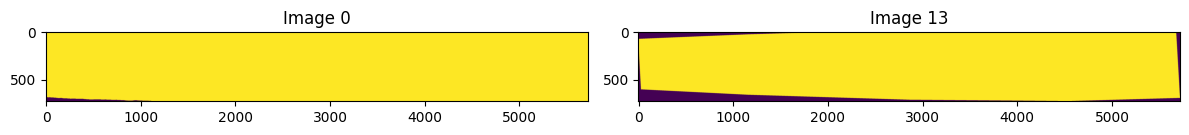

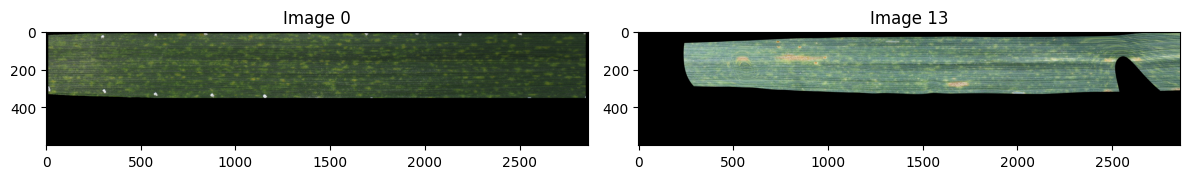

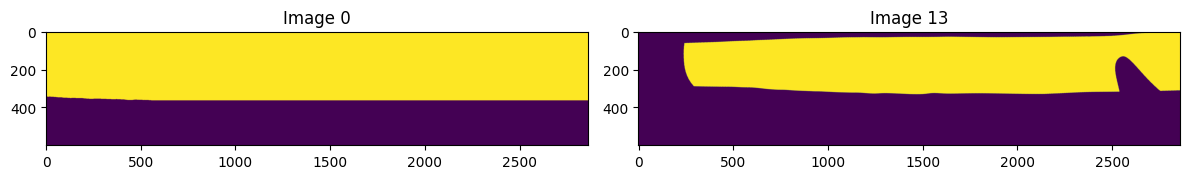

In [18]:
# loftr good, piecewise less good
moving_ind = 13

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070023_8", 
    load=('target_images', 'target_masks', 'leaf_masks', 'rois', 'images', 'keypoints'),
    verbose=False
)

fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI", old=True)
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
# fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI with Markers")
# fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
# fig.show()
# fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
# fig.show()

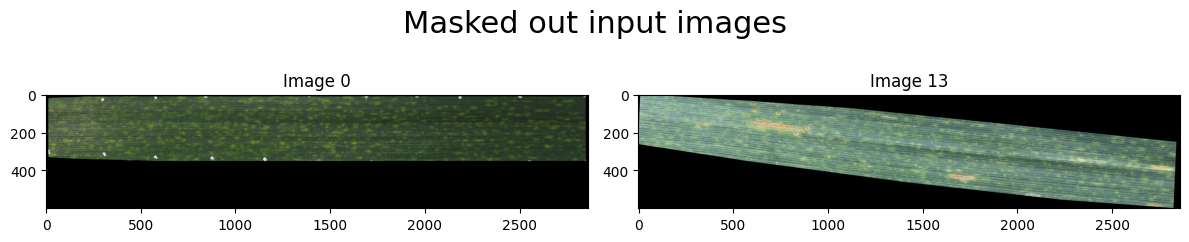

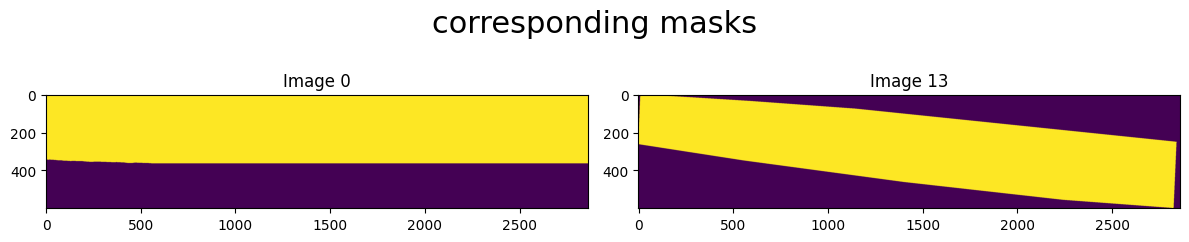

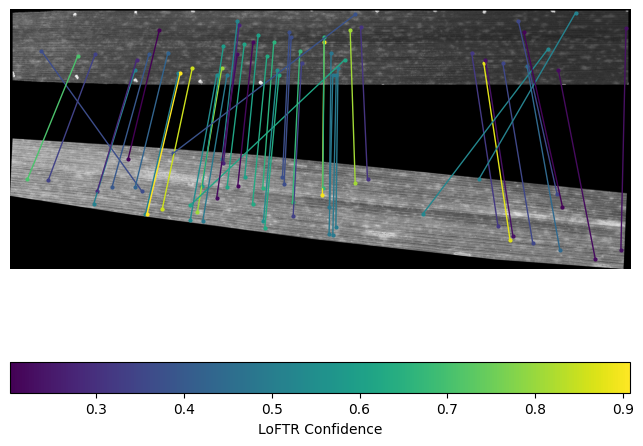

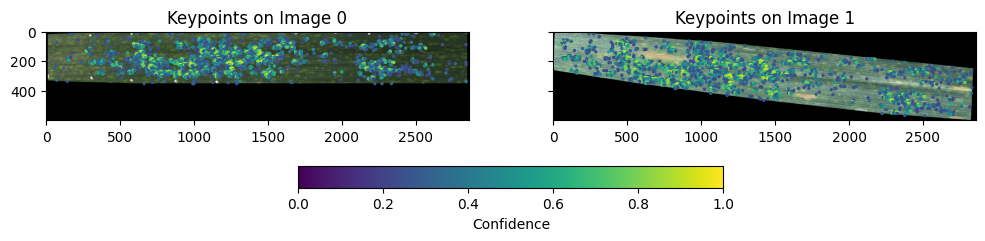

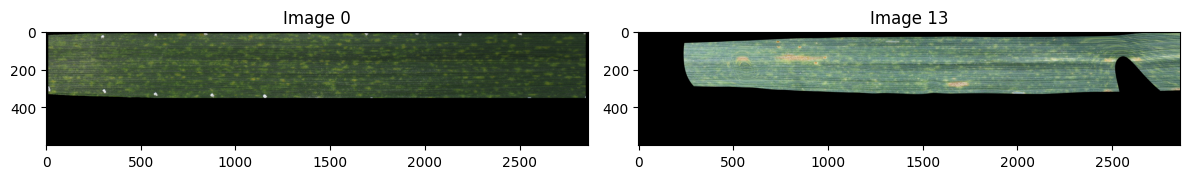

In [19]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI", old=True, plot_masked_images=True, plot_loftr_matches=True)
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()

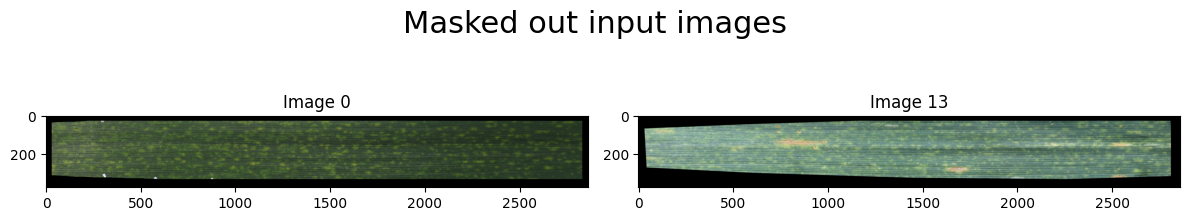

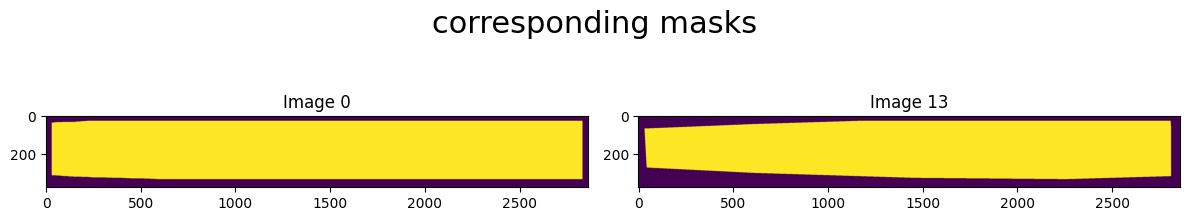

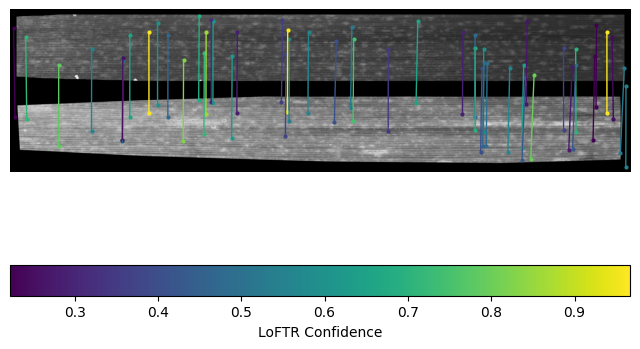

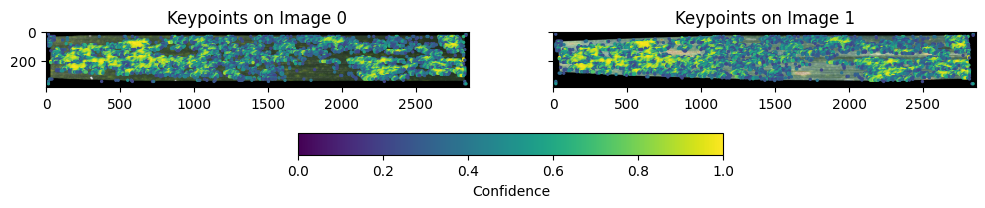

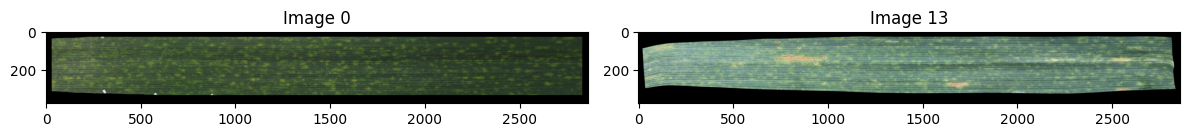

In [20]:
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI", plot_masked_images=True, plot_loftr_matches=True)
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()

In [24]:
df_full.sort_values(["MI"], ascending=False).head(7)

leaf_uid registration_method  fixed_image  moving_image       MSE  \
402   ESWW0070023_5     LoFTR + TPS ROI            0             1  0.003527   
506   ESWW0070023_9     LoFTR + TPS ROI            0             1  0.010650   
289  ESWW0070023_10     Pairwise Affine            0             1  0.008278   
476   ESWW0070023_8     LoFTR + TPS ROI            0             1  0.016635   
480   ESWW0070023_8     LoFTR + TPS ROI            0             5  0.009766   
491   ESWW0070023_9     Pairwise Affine            0             1  0.013271   
290  ESWW0070023_10     Pairwise Affine            0             2  0.009582   

          NCC        MI      SSIM       IoU  Hausdorff  
402  0.705855  1.077173  0.734989  0.982719  17.000000  
506  0.754358  1.072842  0.763037  0.963806  18.110771  
289  0.228845  1.064466  0.458446  0.942078  70.000000  
476  0.658201  1.063523  0.657549  0.956137  31.000000  
480  0.662146  1.060622  0.659368  0.968399  26.000000  
491  0.358649  1.059374  0.472423  0.928104  62.514000  
290  0.343835  1.058519  0.481673  0.942035  70.000000

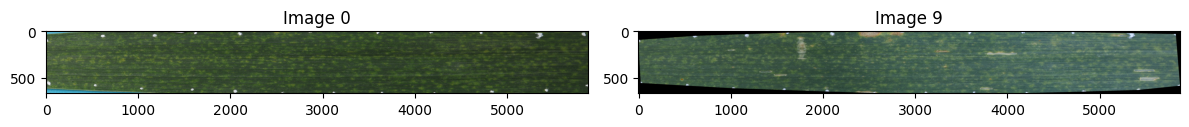

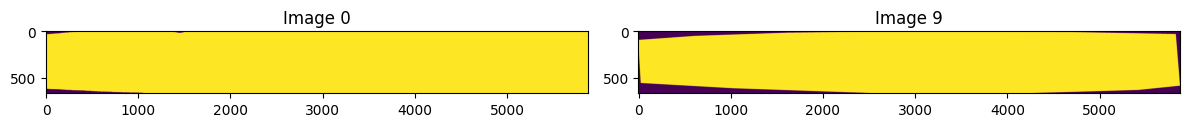

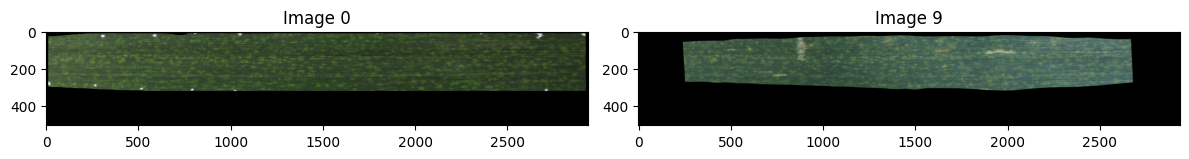

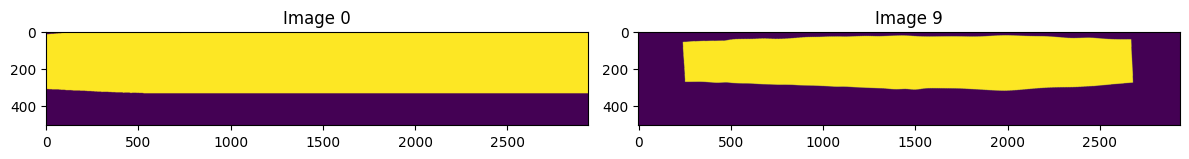

In [ ]:
# loftr good, piecewise less good
moving_ind = 9

leaf = LeafDataset(
    base_dir='../leaf-image-sequences',
    leaf_uid="ESWW0070023_9", 
    load=('target_images', 'target_masks', 'leaf_masks', 'rois', 'images', 'keypoints'),
    verbose=False
)

fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "Pairwise Affine")
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI", old=True)
fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
fig.show()
fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
fig.show()
# fixed, moving, fixed_mask, moving_mask = fetch_image_mask_pair(leaf, 0, moving_ind, "LoFTR + TPS ROI with Markers")
# fig, ax = plot_image_pair(fixed, convert_image_to_tensor(moving), 0, moving_ind)
# fig.show()
# fig, ax = plot_image_pair(fixed_mask, convert_image_to_tensor(moving_mask), 0, moving_ind)
# fig.show()

## With vs Without Markers

In [54]:
common_leaves = set(df_full[df_full['registration_method']=='LoFTR + TPS ROI']['leaf_uid']) & set(df_full[df_full['registration_method']=='LoFTR + TPS ROI with Markers']['leaf_uid'])
df_paired = df_full[df_full['leaf_uid'].isin(common_leaves)]
df_paired = df_paired[df_paired['registration_method'] != "Pairwise Affine"]
df_paired_melt = df_paired.melt(id_vars=['leaf_uid','registration_method', 'fixed_image','moving_image'], value_vars=['MSE', 'NCC', 'MI', 'SSIM', 'IoU', 'Hausdorff'],)
print(df_paired['leaf_uid'].nunique())
df_paired.head()

4


leaf_uid registration_method  fixed_image  moving_image       MSE  \
13  ESWW0070020_1     LoFTR + TPS ROI            0             1  0.004503   
14  ESWW0070020_1     LoFTR + TPS ROI            0             2  0.021916   
15  ESWW0070020_1     LoFTR + TPS ROI            0             3  0.007644   
16  ESWW0070020_1     LoFTR + TPS ROI            0             4  0.027876   
17  ESWW0070020_1     LoFTR + TPS ROI            0             5  0.028360   

         NCC        MI      SSIM       IoU  Hausdorff  
13  0.057931  1.007095  0.416417  0.943841  25.019993  
14  0.020453  1.001438  0.362952  0.872782  65.000000  
15  0.073524  1.001737  0.325642  0.937827  24.000000  
16  0.077442  1.004736  0.294951  0.976703  18.027756  
17  0.049429  1.001678  0.276062  0.925476  28.442924

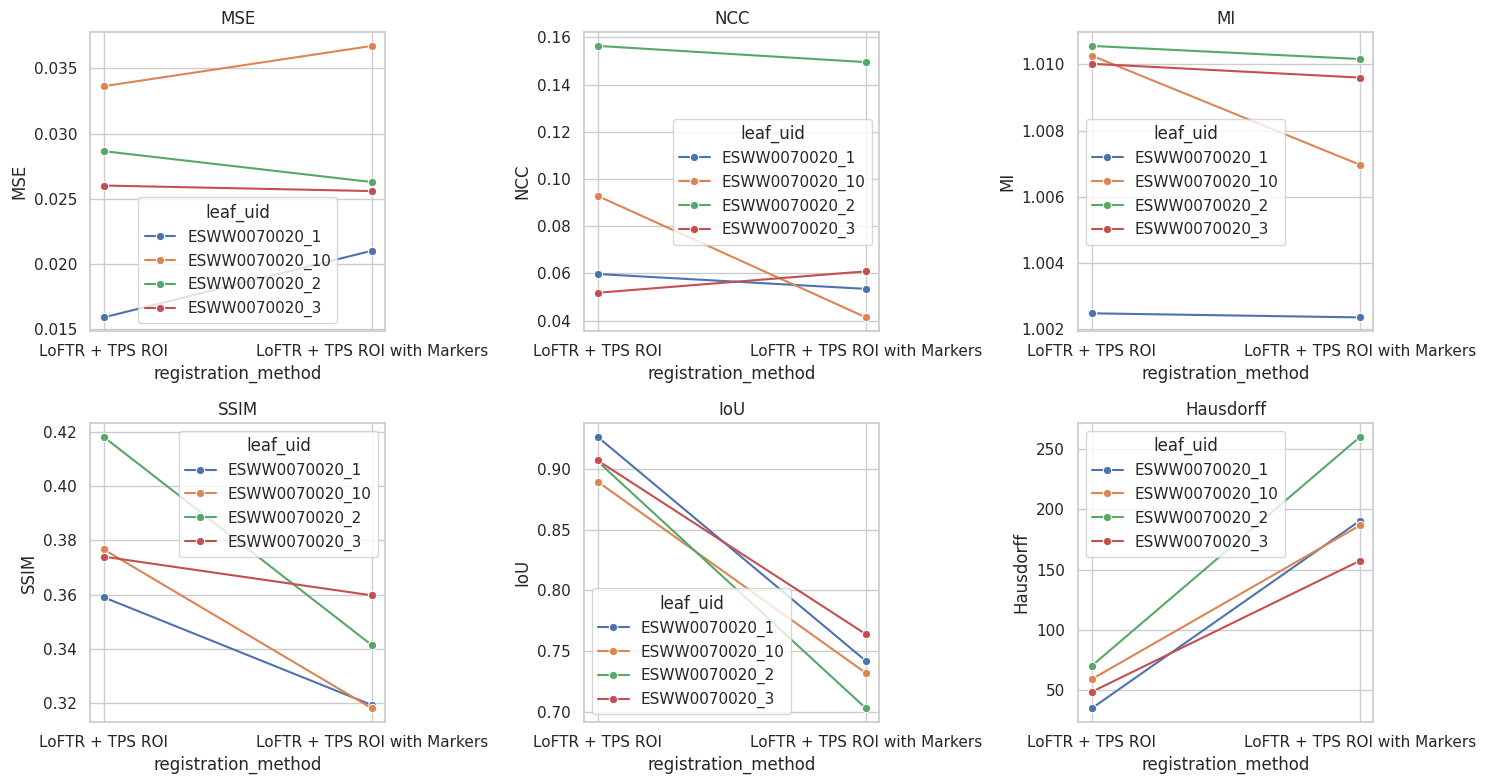

In [67]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False)

for ax, metric in zip(axes.flatten(), metrics):
    df_m = df_paired[['leaf_uid', 'registration_method', metric]]
    sns.lineplot(data=df_m, x='registration_method', y=metric, hue='leaf_uid', marker='o', ax=ax, errorbar=None)
    ax.set_title(metric)

plt.tight_layout()
plt.show()

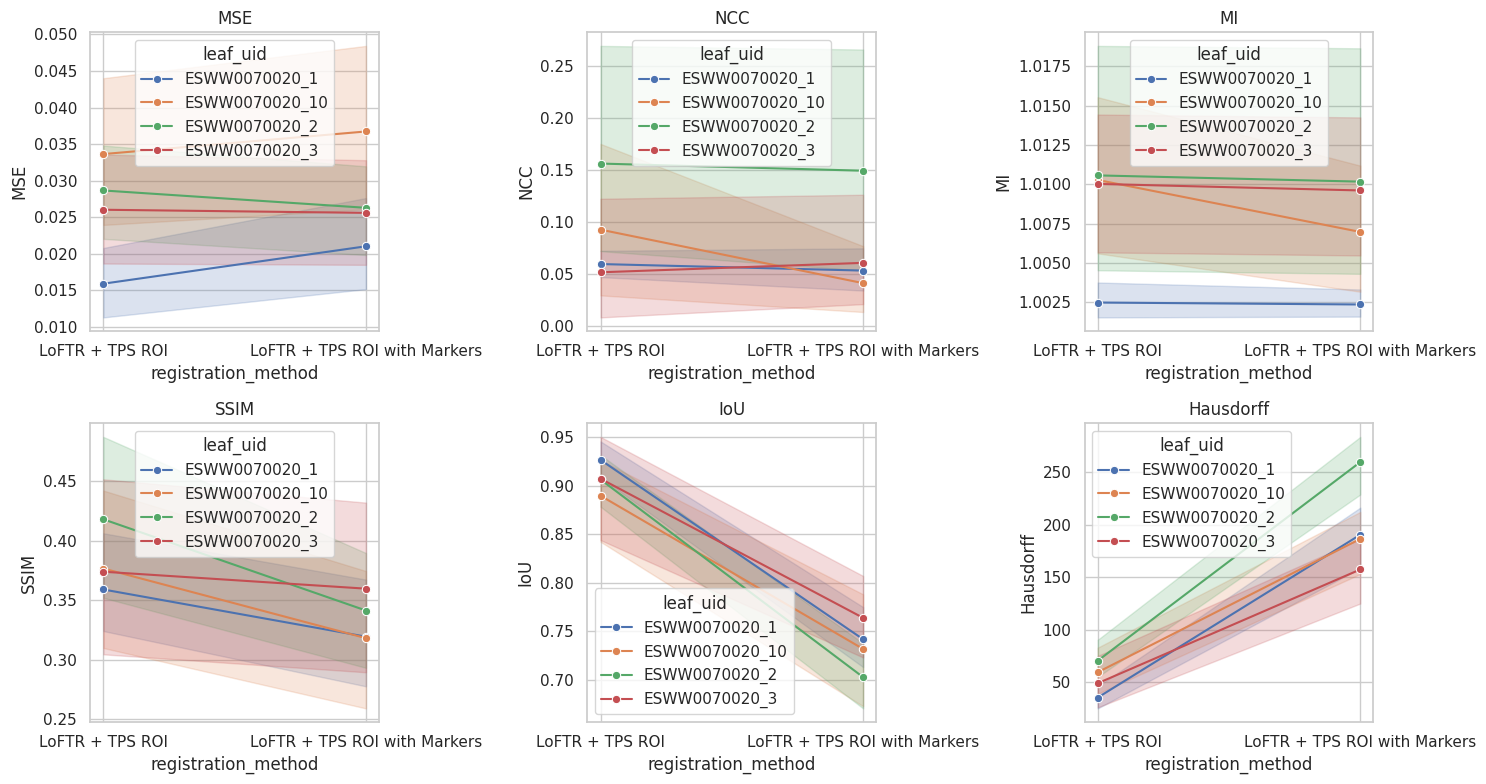

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False)

for ax, metric in zip(axes.flatten(), metrics):
    df_m = df_paired[['leaf_uid', 'registration_method', metric]]
    sns.lineplot(data=df_m, x='registration_method', y=metric, hue='leaf_uid', marker='o', ax=ax)
    ax.set_title(metric)

plt.tight_layout()
plt.show()

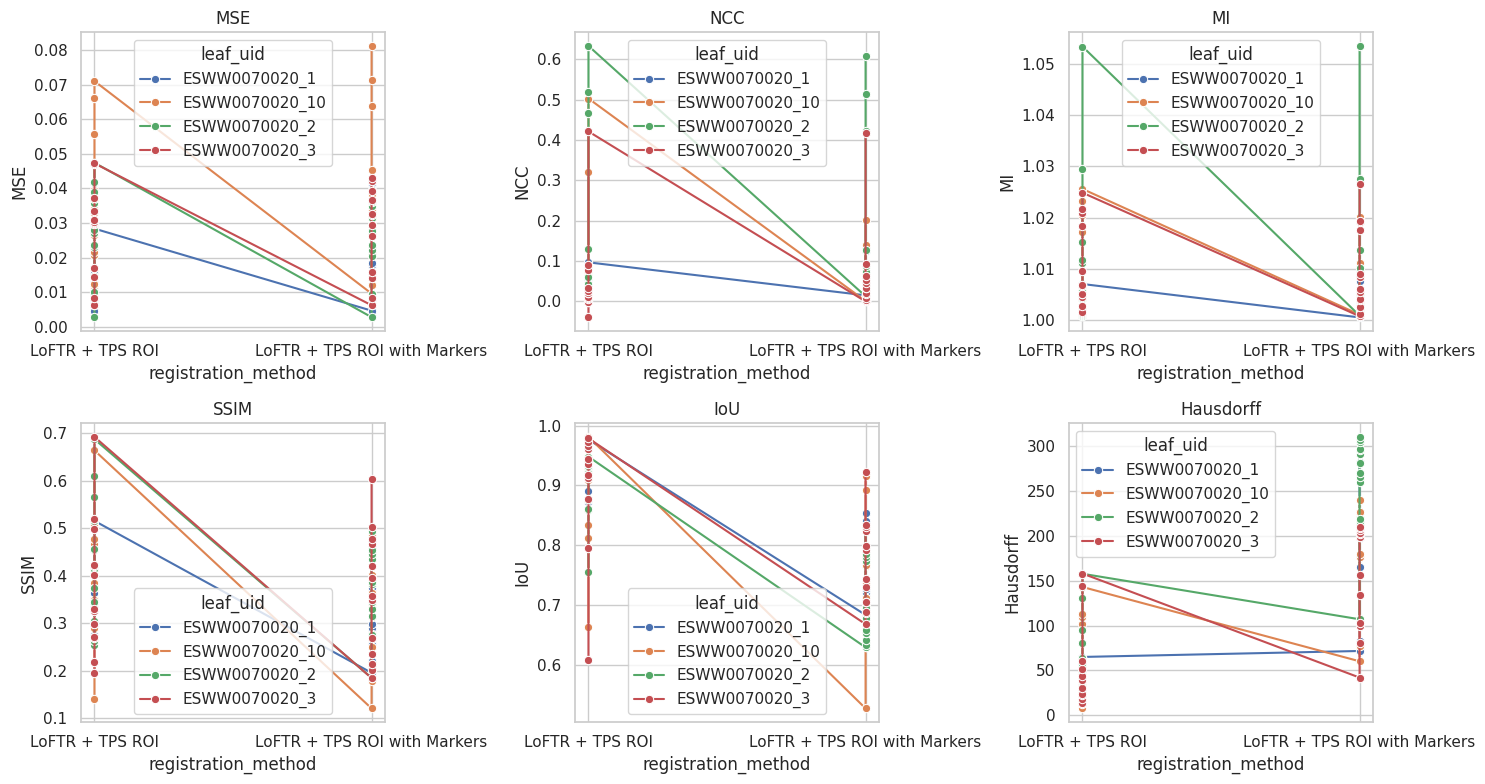

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False)

for ax, metric in zip(axes.flatten(), metrics):
    df_m = df_paired[['leaf_uid', 'registration_method', metric]]
    sns.lineplot(data=df_m, x='registration_method', y=metric, hue='leaf_uid', marker='o', ax=ax, estimator=None, errorbar=None)
    ax.set_title(metric)

plt.tight_layout()
plt.show()

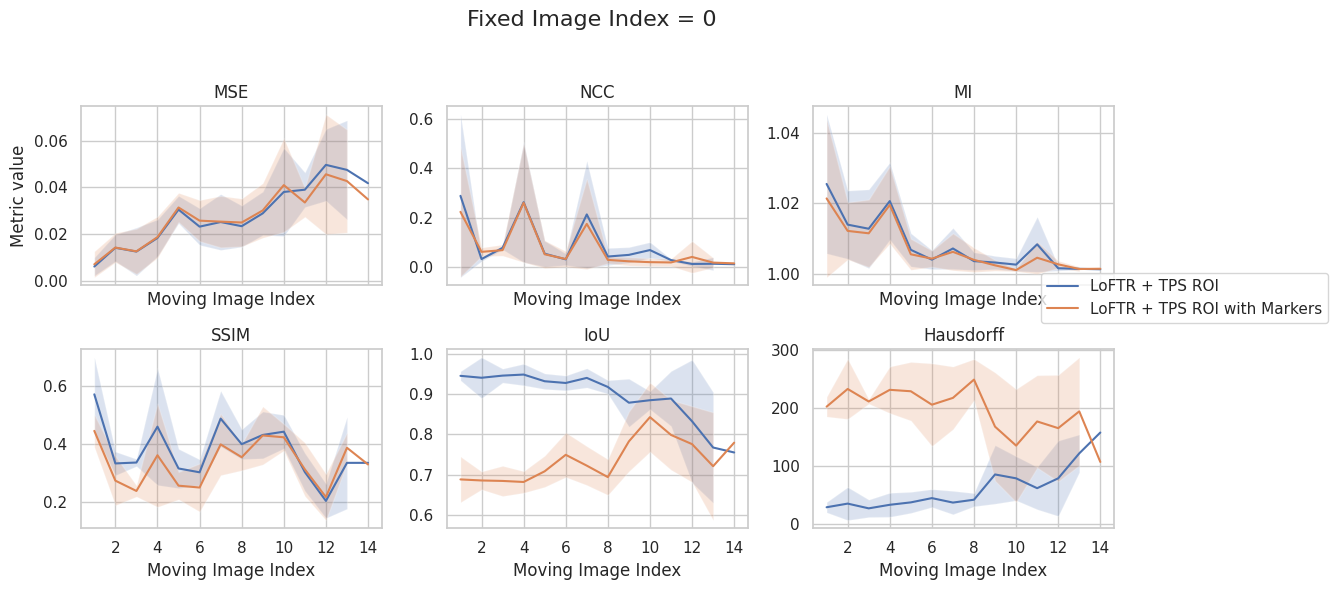

In [70]:
# average over leaf series for each index pair
df_agg = df_paired.groupby(['registration_method', 'fixed_image', 'moving_image'])[metrics].agg(["mean", "std"]).reset_index()
df_agg.columns = [ "_".join(col).rstrip("_") for col in df_agg.columns ]
df_agg.sample(5).sort_values(by=(['registration_method', 'fixed_image', 'moving_image']))

methods = ["LoFTR + TPS ROI", "LoFTR + TPS ROI with Markers"]
n_metrics = len(metrics)

n_rows = 2
n_cols = math.ceil(n_metrics / n_rows)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex=True,
    sharey=False
)

axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    for method in methods:
        df_plot = df_agg[
            (df_agg["fixed_image"] == 0) &
            (df_agg["registration_method"] == method) &
            (df_agg["moving_image"] != 0)
        ].sort_values("moving_image")

        if df_plot.empty:
            continue

        x = df_plot["moving_image"]
        mean = df_plot[f"{metric}_mean"]
        std = df_plot[f"{metric}_std"]

        ax.plot(x, mean, label=method)
        ax.fill_between(x, mean - std, mean + std, alpha=0.2, label="_nolegend_")

    ax.set_title(metric)
    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Moving Image Index")

# hide unused subplots
for ax in axes[len(metrics):]:
    ax.set_visible(False)

# shared y-label
axes[0].set_ylabel("Metric value")

# put legend far right outside
fig.legend(
    methods,
    loc="center right",
    bbox_to_anchor=(1.12, 0.5)
)

fig.suptitle("Fixed Image Index = 0", fontsize=16)

# tighten layout to remove empty space
fig.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


## Variance Analysis

In [23]:
rows = []

for keys, g in df_full.groupby(group_cols):
    n = g["leaf_uid"].nunique() # number of samples
    if n < 2:
        # not enough samples to compute sample variance
        continue

    tval = t.ppf(0.975, n - 1)

    # compute confidence interval half-width for each metric
    for metric in metrics:
        s = g[metric].std(ddof=1) # sample standard deviation
        half_width = tval * s / np.sqrt(n) # width of confidence interval
        m = g[metric].mean()
        
        rows.append({
            "registration_method": keys[0],
            "fixed_image": keys[1],
            "moving_image": keys[2],
            "metric": metric,
            "mean": m,
            "ci_half_width": half_width,            
        })

ci_param_df = pd.DataFrame(rows)
ci_param_df.head(5)


registration_method  fixed_image  moving_image metric      mean  \
0     LoFTR + TPS ROI            0             1    MSE  0.007963   
1     LoFTR + TPS ROI            0             1    NCC  0.185808   
2     LoFTR + TPS ROI            0             1     MI  1.020832   
3     LoFTR + TPS ROI            0             1   SSIM  0.487167   
4     LoFTR + TPS ROI            0             1    IoU  0.917000   

   ci_half_width  
0       0.001651  
1       0.097086  
2       0.007947  
3       0.054920  
4       0.030367

In [27]:
metric_tol = (
    ci_param_df
    .groupby(["registration_method", "metric"])#["ci_half_width"]
    #.max()
    .agg( overall_mean=("mean", "mean"), max_ci_half_width=("ci_half_width", "max"))
    .reset_index()
)
rel_tol = 0.05 # 5% relative tolerance
metric_tol["tolerance"] = rel_tol * metric_tol["overall_mean"].abs()
metric_tol["Confident"] = metric_tol["max_ci_half_width"] <= metric_tol["tolerance"]
metric_tol['n_target'] = np.ceil(n_uids * (metric_tol['max_ci_half_width'] / metric_tol['tolerance'])**2).astype(int)
metric_tol

registration_method metric  overall_mean  max_ci_half_width  tolerance  \
0         LoFTR + TPS     MI      1.017236           0.004566   0.050862   
1         LoFTR + TPS    MSE      0.043189           0.303678   0.002159   
2         LoFTR + TPS    NCC      0.099139           0.043457   0.004957   
3         LoFTR + TPS   SSIM      0.695947           0.072285   0.034797   
4     Pairwise Affine     MI      1.016601           0.067343   0.050830   
5     Pairwise Affine    MSE      0.038126           0.382457   0.001906   
6     Pairwise Affine    NCC      0.061739           0.141039   0.003087   
7     Pairwise Affine   SSIM      0.297321           0.146280   0.014866   

   Confident  n_target  
0       True         1  
1      False   1245915  
2      False      4843  
3      False       272  
4      False       111  
5      False   2535788  
6      False    131512  
7      False      6100

For each registration method and metric, the half-width of the Confidence Interval $CI$ indicates that the true mean of that metric lies within $\pm CI$ with probability $95\%$.  
The tolerance is relative to the mean over all metric values, with a relative tolerance of $5\%$.  
`n_target` is an estimate of how many samples would be needed to achieve the desired tolerance.  